# Hệ khuyến nghị. IUH 2025.
### Ngày 28/8/2025. Lab 2.
**Mục tiêu:** thực hành dự đoán rating dựa vào lọc cộng tác (2 cách user-based & item-based); content-based cơ bản.

**Problem 1.** Given the rating table of 4 users $U_1, U_2, U_3, U_4$ and 4 items $I_1, I_2, I_3, I_4$ as follows:

|Rating     | $I_1$    | $I_2$  | $I_3$   |  $I_4$  |
|----------|----------|--------|---------|---------|
| $U_1$    | 4     | 3     | ?    |   4 | 
| $U_2$ | 3     | 3      | 5     |   ?    |
| $U_3$  | 5     | 4      |   1  |    4 |
| $U_4$|  4   |   2    | 3 |   5|

Predict the rating $r(U_1,I_3)$ and $r(U_2, I_4)$ by using (có thể tham khảo lại slide bài giảng buổi 3-4):

a) User-based;

b) Item-based.

In [3]:
# Sử dụng user-based
#CODE HERE
import numpy as np, pandas as pd

# Data
users=["U1","U2","U3","U4"]
items=["I1","I2","I3","I4"]
R=pd.DataFrame([
    [4,3,np.nan,4],
    [3,3,5,np.nan],
    [5,4,1,4],
    [4,2,3,5]
], index=users, columns=items).astype(float)

def user_means(df): 
    return df.mean(axis=1, skipna=True)

# Pearson similarity between users
def pearson_user_sim(df):
    means=user_means(df)
    sim=pd.DataFrame(np.eye(len(df)),index=df.index,columns=df.index)
    for u in df.index:
        for v in df.index:
            if u==v: continue
            both=df.loc[[u,v]].dropna(axis=1, how="any")
            if both.shape[1]<2: sim.loc[u,v]=0.0; continue
            a=both.loc[u]-means[u]; b=both.loc[v]-means[v]
            num=float(np.dot(a,b)); den=float(np.linalg.norm(a)*np.linalg.norm(b))
            sim.loc[u,v]=0.0 if den==0 else num/den
    return sim

# Adjusted-cosine similarity between items
def adjusted_cosine_item_sim(df):
    means=user_means(df)
    centered=df.sub(means, axis=0)
    sim=pd.DataFrame(np.eye(df.shape[1]), index=df.columns, columns=df.columns)
    for i in df.columns:
        for j in df.columns:
            if i==j: continue
            both=centered[[i,j]].dropna(axis=0, how="any")
            if both.shape[0]==0: sim.loc[i,j]=0.0; continue
            a=both[i].to_numpy(); b=both[j].to_numpy()
            num=float(np.dot(a,b)); den=float(np.linalg.norm(a)*np.linalg.norm(b))
            sim.loc[i,j]=0.0 if den==0 else num/den
    return sim


# User-based prediction
def predict_user_based(df,u,i,sim):
    mu=user_means(df)[u]
    nbrs=df[i].dropna().index.drop(u, errors="ignore")
    if len(nbrs)==0: return mu
    num=den=0.0
    for v in nbrs:
        s=sim.loc[u,v]; mu_v=user_means(df)[v]
        num += s*(df.loc[v,i]-mu_v); den += abs(s)
    return mu if den==0 else mu+num/den

user_sim=pearson_user_sim(R)
print("User-based:")
print(" r(U1,I3) =", round(predict_user_based(R,"U1","I3",user_sim),3))
print(" r(U2,I4) =", round(predict_user_based(R,"U2","I4",user_sim),3))


User-based:
 r(U1,I3) = 3.225
 r(U2,I4) = 3.372


$${{w}_{i,j}}=\frac{\sum\limits_{u\in U}^{{}}{({{r}_{u,i}}-{{\overline{r}}_{i}})({{r}_{u,j}}-\overline{{{r}_{j}}})}}{\sqrt{\sum\limits_{u\in U}^{{}}{{{\left( {{r}_{u,i}}-\overline{{{r}_{i}}} \right)}^{2}}}}\sqrt{\sum\limits_{u\in U}^{{}}{{{\left( {{r}_{u,j}}-\overline{{{r}_{j}}} \right)}^{2}}}}}$$

$${{P}_{a,i}}={{\overline{r}}_{a}}+\frac{\sum\limits_{u\in U}^{{}}{({{r}_{u,i}}-{{r}_{u}}){{w}_{a,u}}}}{\sum\limits_{u\in U}^{{}}{\left| {{w}_{a,u}} \right|}}$$

In [4]:
# Item-based prediction
def predict_item_based(df,u,i,sim):
    mu=user_means(df)[u]
    rated=[j for j in df.loc[u].dropna().index if j!=i]
    if len(rated)==0: return mu
    num=den=0.0
    for j in rated:
        s=sim.loc[i,j]; num += s*(df.loc[u,j]-mu); den += abs(s)
    return mu if den==0 else mu+num/den

item_sim=adjusted_cosine_item_sim(R)
print("Item-based:")
print(" r(U1,I3) =", round(predict_item_based(R,"U1","I3",item_sim),3))
print(" r(U2,I4) =", round(predict_item_based(R,"U2","I4",item_sim),3))

Item-based:
 r(U1,I3) = 3.492
 r(U2,I4) = 3.385


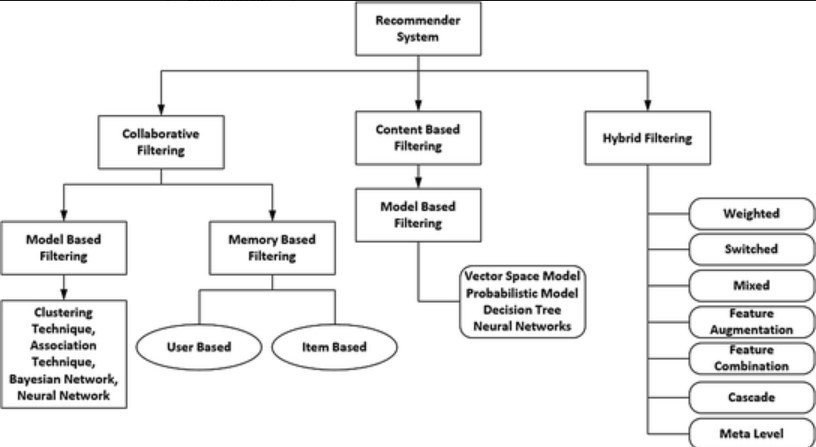

**Problem 2.** Ở bài này, SV dựa theo file dữ liệu metadata.csv với các cột (movieId, title, genres, vote_count, vote_average) để thực hiện bài bên dưới. Chú ý rằng nếu có cột nào mà tên chưa giống như trong lab thì SV tự điều chỉnh lại.

**Creating content-based data**

In this exersise, we using the DataFrame user_ratings_df, which is a subset of the Movie Lens dataset. As much as you might want to jump right to finding similar items and making recommendations, you first need to get your data in a usable format. You will explore your base data and work through how to format that data to be used for content-based recommendations.

As a reminder, the desired outcome is a row per movie with each column indicating whether a genre applies to the movie. You will be looking at movie_genre_df, which contains these columns:

- *name* - Name of movie
- *genre_list* - Genre that the movie has been labeled as
  
A movie may have multiple genres, and therefore multiple rows. In this exercise, you will particularly focus on one movie (Toy Story in this case) to be able to clearly see what is happening with the data.

In [5]:
import pandas as pd

# Đọc dữ liệu
df = pd.read_csv("metadata.csv")

# Đổi tên cột cho khớp với đề
df = df.rename(columns={"title":"name"})

# Tách genres ra nhiều dòng
movie_genre_df = df.assign(genre_list=df['genres'].str.split('|')).explode('genre_list')

print(movie_genre_df.head(10))


   movieId                     name  \
0        1         Toy Story (1995)   
0        1         Toy Story (1995)   
0        1         Toy Story (1995)   
0        1         Toy Story (1995)   
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
1        2           Jumanji (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  vote_count  vote_average  \
0  Adventure|Animation|Children|Comedy|Fantasy         215      3.920930   
0  Adventure|Animation|Children|Comedy|Fantasy         215      3.920930   
0  Adventure|Animation|Children|Comedy|Fantasy         215      3.920930   
0  Adventure|Animation|Children|Comedy|Fantasy         215      3.920930   
0  Adventure|Animation|Children|Comedy|Fantasy         215      3.920930   
1                   Adventure|Children|Fantasy         110      3.431818   
1                   Adventure|Children

In [7]:
#CODE HERE
toy_story_genres = movie_genre_df[movie_genre_df['name'].str.contains('Toy Story')]
print(toy_story_genres)

movie_cross_table = pd.crosstab(movie_genre_df['name'], movie_genre_df['genre_list'])

# Xem riêng Toy Story
toy_story_genres_ct = movie_cross_table[movie_cross_table.index.str.contains('Toy Story')]
print(toy_story_genres_ct)

      movieId                name  \
0           1    Toy Story (1995)   
0           1    Toy Story (1995)   
0           1    Toy Story (1995)   
0           1    Toy Story (1995)   
0           1    Toy Story (1995)   
2353     3114  Toy Story 2 (1999)   
2353     3114  Toy Story 2 (1999)   
2353     3114  Toy Story 2 (1999)   
2353     3114  Toy Story 2 (1999)   
2353     3114  Toy Story 2 (1999)   
7338    78499  Toy Story 3 (2010)   
7338    78499  Toy Story 3 (2010)   
7338    78499  Toy Story 3 (2010)   
7338    78499  Toy Story 3 (2010)   
7338    78499  Toy Story 3 (2010)   
7338    78499  Toy Story 3 (2010)   

                                                genres  vote_count  \
0          Adventure|Animation|Children|Comedy|Fantasy         215   
0          Adventure|Animation|Children|Comedy|Fantasy         215   
0          Adventure|Animation|Children|Comedy|Fantasy         215   
0          Adventure|Animation|Children|Comedy|Fantasy         215   
0          Adventure

**Understanding the content-based data**

You are now able to convert common attribute data to a DataFrame containing a row per movie, and each of its attributes as columns. You will now take a closer look at the full DataFrame you just created to see if you understand the information within.

A subset of the DataFrame you have created in the last exercise has been loaded as movie_cross_table. As a reminder, the genres are stored as individual columns and the movie names are stored as the index.

Inspect the rows corresponding to *Toy Story* and *Yogi Bear* in movie_cross_table. How many genres do they have in common?

In [8]:
#CODE HERE
yogi_story_genres_ct = movie_cross_table[movie_cross_table.index == 'Yogi Bear']


# Lấy vector của Toy Story và Yogi Bear
toy_story_ct = movie_cross_table[movie_cross_table.index.str.contains('Toy Story')].iloc[0]
yogi_bear_ct = movie_cross_table[movie_cross_table.index.str.contains('Yogi Bear')].iloc[0]

# Đếm số genre chung
common_genres = (toy_story_ct & yogi_bear_ct).sum()
print("Số lượng genres chung giữa Toy Story và Yogi Bear:", common_genres)


Số lượng genres chung giữa Toy Story và Yogi Bear: 2


**Comparing individual movies with Jaccard similarity**

In the last lesson, you built a DataFrame of movies, where each column represents a different genre. You can now use this DataFrame to compare movies by measuring the Jaccard similarity between rows. The higher the Jaccard similarity score, the more similar the two items are. In this exercise, you will compare the movie GoldenEye with the movie Toy Story, and GoldenEye with SkyFall and compare the results.

The DataFrame *movie_cross_table* containing all the movies as rows and the genres as Boolean columns that you created in the last lesson has been loaded.

In [9]:
# Import numpy and the Jaccard similarity function
# Import numpy và hàm jaccard_score
import numpy as np
from sklearn.metrics import jaccard_score

# Lấy vector genres cho từng phim
goldeneye = movie_cross_table[movie_cross_table.index.str.contains('GoldenEye')].iloc[0].to_numpy()
toystory = movie_cross_table[movie_cross_table.index.str.contains('Toy Story')].iloc[0].to_numpy()
skyfall   = movie_cross_table[movie_cross_table.index.str.contains('Skyfall')].iloc[0].to_numpy()

# Tính Jaccard similarity
sim_goldeneye_toystory = jaccard_score(goldeneye, toystory, average='binary')
sim_goldeneye_skyfall  = jaccard_score(goldeneye, skyfall, average='binary')

print("Jaccard similarity GoldenEye vs Toy Story:", sim_goldeneye_toystory)
print("Jaccard similarity GoldenEye vs Skyfall:", sim_goldeneye_skyfall)


Jaccard similarity GoldenEye vs Toy Story: 0.14285714285714285
Jaccard similarity GoldenEye vs Skyfall: 0.75


**Hints**
- Import the Jaccard similarity score function from sklearn.metrics.
- Convert the rows containing 'GoldenEye' and 'Toy Story' to numpy arrays and measure their similarity.
- Convert the row containing Skyfall to a numpy array and measure its similarity to GoldenEye.

**Comparing all your movies at once**

While finding the Jaccard similarity between any two individual movies in your dataset is great for small-scale analyses, it can prove slow on larger datasets to make recommendations. In this exercise, you will find the similarities between all movies and store them in a DataFrame for quick and easy lookup. When finding the similarities between the rows in a DataFrame, you could run through all pairs and calculate them individually, but it's more efficient to use *pdist()* (pairwise distance) function from scipy.

This can be reshaped into the desired rectangular shape using *squareform()* from the same library. Since you want similarity values as opposed to distances, you should subtract the values from 1. *movie_cross_table* has once again been loaded for you.

In [10]:
# Import functions from scipy
from scipy.spatial.distance import pdist, squareform

# Calculate all pairwise distances
jaccard_distances = pdist(movie_cross_table.values, metric='jaccard')

# Convert the distances to a square matrix
jaccard_similarity_array = 1 - squareform(jaccard_distances)

# Wrap the array in a pandas DataFrame
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, index=movie_cross_table.index, columns=movie_cross_table.index)

# Print the top 5 rows of the DataFrame
print(jaccard_similarity_df.head())

name                                     '71 (2014)  \
name                                                  
'71 (2014)                                 1.000000   
'Hellboy': The Seeds of Creation (2004)    0.125000   
'Round Midnight (1986)                     0.200000   
'Salem's Lot (2004)                        0.333333   
'Til There Was You (1997)                  0.200000   

name                                     'Hellboy': The Seeds of Creation (2004)  \
name                                                                               
'71 (2014)                                                                 0.125   
'Hellboy': The Seeds of Creation (2004)                                    1.000   
'Round Midnight (1986)                                                     0.000   
'Salem's Lot (2004)                                                        0.000   
'Til There Was You (1997)                                                  0.000   

name                     

**Hints**
- Find the Jaccard distance measures between all movies and assign the results to jaccard_similarity_array.
- Create a DataFrame from the jaccard_similarity_array with movie_genre_df.index as its rows and columns.
- Print the top 5 rows of the DataFrame and examine the similarity scores.

**Making recommendations based on movie genres**

Now that you have your data in a usable format and know how to compare two movies, the next step is to use this to generate recommendations. In this exercise, you will learn how to generate recommendations for any movie in your dataset. The similarity scores between all movies in the dataset that you calculated in the last exercise have been pre-loaded for you as jaccard_similarity_array. movie_cross_table containing the movies and their attributes is also available.

For ease of use, you will need to wrap the similarity scores in a DataFrame. Then you will use this new DataFrame to suggest a movie recommendation.

In [15]:
# Wrap the preloaded array in a DataFrame
jaccard_similarity_df = jaccard_similarity_df.reindex(index=movie_cross_table.index, columns=movie_cross_table.index)

# Find the values for the movie 71 (2014)
jaccard_similarity_series = jaccard_similarity_df["'71 (2014)"]

# Sort these values from highest to lowest
ordered_similarities = jaccard_similarity_series.sort_values(ascending=False)

# Print the results
print(ordered_similarities)

name
Lone Survivor (2013)                                               1.0
Throne of Blood (Kumonosu jô) (1957)                               1.0
Battle Royale 2: Requiem (Batoru rowaiaru II: Chinkonka) (2003)    1.0
Hurt Locker, The (2008)                                            1.0
Dunkirk (2017)                                                     1.0
                                                                  ... 
Kevin Hart: Laugh at My Pain (2011)                                0.0
Kevin Hart: I'm a Grown Little Man (2009)                          0.0
Kentucky Fried Movie, The (1977)                                   0.0
Kama Sutra: A Tale of Love (1996)                                  0.0
2 Days in New York (2012)                                          0.0
Name: '71 (2014), Length: 9719, dtype: float64


**Hints**
- Generate a DataFrame called jaccard_similarity_df from jaccard_similarity_array.
- Store the similarity values between Thor and all other movies as a Series.
- Sort these from largest to smallest in ordered_similarities.